DataSet:

- You can use the "Household Power Consumption" dataset, which contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. The dataset is publicly available from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption 

Problem Statements:

- Understanding household electricity consumption patterns. Identify factors influencing electricity usage and develop predictive models to forecast future consumption accurately.

# Data Collection and Exploration:

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from scipy.stats import trim_mean
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import xgboost as xgb
import joblib
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';')

In [3]:
df = data.copy()

In [4]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


- From the variables definition we need to change some feature type

In [6]:
# Count no. of null values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [7]:
# null percentage
df.isnull().sum() / len(df)

Date                     0.000000
Time                     0.000000
Global_active_power      0.000000
Global_reactive_power    0.000000
Voltage                  0.000000
Global_intensity         0.000000
Sub_metering_1           0.000000
Sub_metering_2           0.000000
Sub_metering_3           0.012518
dtype: float64

In [8]:
df['Date'].value_counts()

Date
6/12/2008     1440
9/8/2009      1440
7/8/2009      1440
6/8/2009      1440
5/8/2009      1440
              ... 
5/4/2008      1440
4/4/2008      1440
24/11/2010    1440
26/11/2010    1263
16/12/2006     396
Name: count, Length: 1442, dtype: int64

- As the data contains every min in each day so we should have 1440 recoreds per day.
- Also, we need to check if the data have any missed day.

In [9]:
# Add Date and Time then convert to datetime type, drop time column and re-sort index
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.drop('Time', axis=1 , inplace=True)
df.sort_values('Date').reset_index(inplace=True)

## Check if there is any missied day

In [10]:
# Generate the complete date range
full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())

# Check for missing date / time
missing_days = set(full_date_range) - set(df['Date'])

missing_days

set()

# Data Preprocessing:

In [11]:
df[df['Sub_metering_3'].isna()]

,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,2006-12-21 11:23:00,?,?,?,?,?,?,NaN
6840,2006-12-21 11:24:00,?,?,?,?,?,?,NaN
19724,2006-12-30 10:08:00,?,?,?,?,?,?,NaN
19725,2006-12-30 10:09:00,?,?,?,?,?,?,NaN
41832,2007-01-14 18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...,...
1990185,2010-09-28 19:09:00,?,?,?,?,?,?,NaN
1990186,2010-09-28 19:10:00,?,?,?,?,?,?,NaN
1990187,2010-09-28 19:11:00,?,?,?,?,?,?,NaN
1990188,2010-09-28 19:12:00,?,?,?,?,?,?,NaN


- The data contains missing values in various places and various orders so, let's check the number of consecutive missing values

In [12]:
# Identify consecutive missing values

test = df.copy()
test['is_null'] = test['Sub_metering_3'].isna()
test['group'] = (~test['is_null']).cumsum()

# Group by consecutive nulls and get consecutive number more than 2
null_groups = test[test['is_null']].groupby('group')
consecutive_nulls = [(group.index[0], group.index[-1], len(group)) for _, group in null_groups if len(group) > 2]

consecutive_nulls

[(190497, 194219, 3723),
 (252031, 252033, 3),
 (252035, 252067, 33),
 (303805, 303887, 83),
 (303897, 303943, 47),
 (327768, 327788, 21),
 (977344, 977386, 43),
 (1000819, 1000824, 6),
 (1043604, 1043673, 70),
 (1120265, 1120302, 38),
 (1142922, 1142945, 24),
 (1283719, 1283721, 3),
 (1309386, 1312690, 3305),
 (1349584, 1349587, 4),
 (1397496, 1398386, 891),
 (1616969, 1620097, 3129),
 (1712788, 1714814, 2027),
 (1929818, 1937043, 7226),
 (1984952, 1990188, 5237)]

- The highest consecutive number of missing values is around 5 days from 17-08-2010 to 22-08-2010

In [13]:
# replace '?' with null
df = df.replace('?', np.NaN)
# convert numeric features to float type
df = df.astype({col: 'float' for col in df.columns[1:]})

## Split the data before any preprocessing to ensure that the test data is unseen
- We have from 16-Dec-2006 to 26-Nov-2010 and I will make the test data for last 3 months 1-Sep-2010 to 26-11-2010

In [14]:
train_data = df[df['Date'] < '2010-09-01'].reset_index(drop=True)
test_data = df[df['Date'] >= '2010-09-01'].reset_index(drop=True)

In [15]:
train_data.shape,test_data.shape

((1950156, 8), (125103, 8))

## missing values
- After Analyzing the distribution of each month - day of week - hour the distribution are vary from one to another so the best solution to fill the missing values with the most same recent minute

In [16]:
def fill_missing_same_minute(df, datetime_col, features):
    """
    Fills missing values in multiple columns with the most recent non-null value 
    that has the same minute from the past.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing a timestamp column and value columns.
    datetime_col (str): Name of the timestamp column.
    features (list): List of columns with missing values to fill.

    Returns:
    pd.DataFrame: DataFrame with new columns 'filled_<column>' for each value column.
    """
    # Extract the minute from the timestamp
    df["minute"] = df[datetime_col].dt.minute

    # Sort the DataFrame by timestamp to ensure chronological order
    df = df.sort_values(datetime_col)

    # Apply forward fill within each minute group for each column
    for col in features:
        df[col] = df.groupby("minute")[col].ffill()

    return df

In [17]:
# List of feature columns to fill
feature_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

# Apply function to multiple columns
train_data_filled = fill_missing_same_minute(train_data, 'Date', feature_cols)
test_data_filled = fill_missing_same_minute(test_data, 'Date', feature_cols)

## Check the distribution before and after fill missing values

In [18]:
def kdeplot(df1, df2, columns):
    # Plot distributions before and after imputation
    fig, axes = plt.subplots(len(columns), 2, figsize=(12, 15), constrained_layout=True)

    for i, feature in enumerate(columns):
        # Original distribution
        sns.kdeplot(df1[feature], ax=axes[i, 0], fill=True, color="blue", label="Original")
        axes[i, 0].set_title(f"Original {feature} Distribution")
        axes[i, 0].legend()
        
        # Imputed distribution
        sns.kdeplot(df2[feature], ax=axes[i, 1], fill=True, color="orange", label="Imputed")
        axes[i, 1].set_title(f"Imputed {feature} Distribution")
        axes[i, 1].legend()

    plt.show()

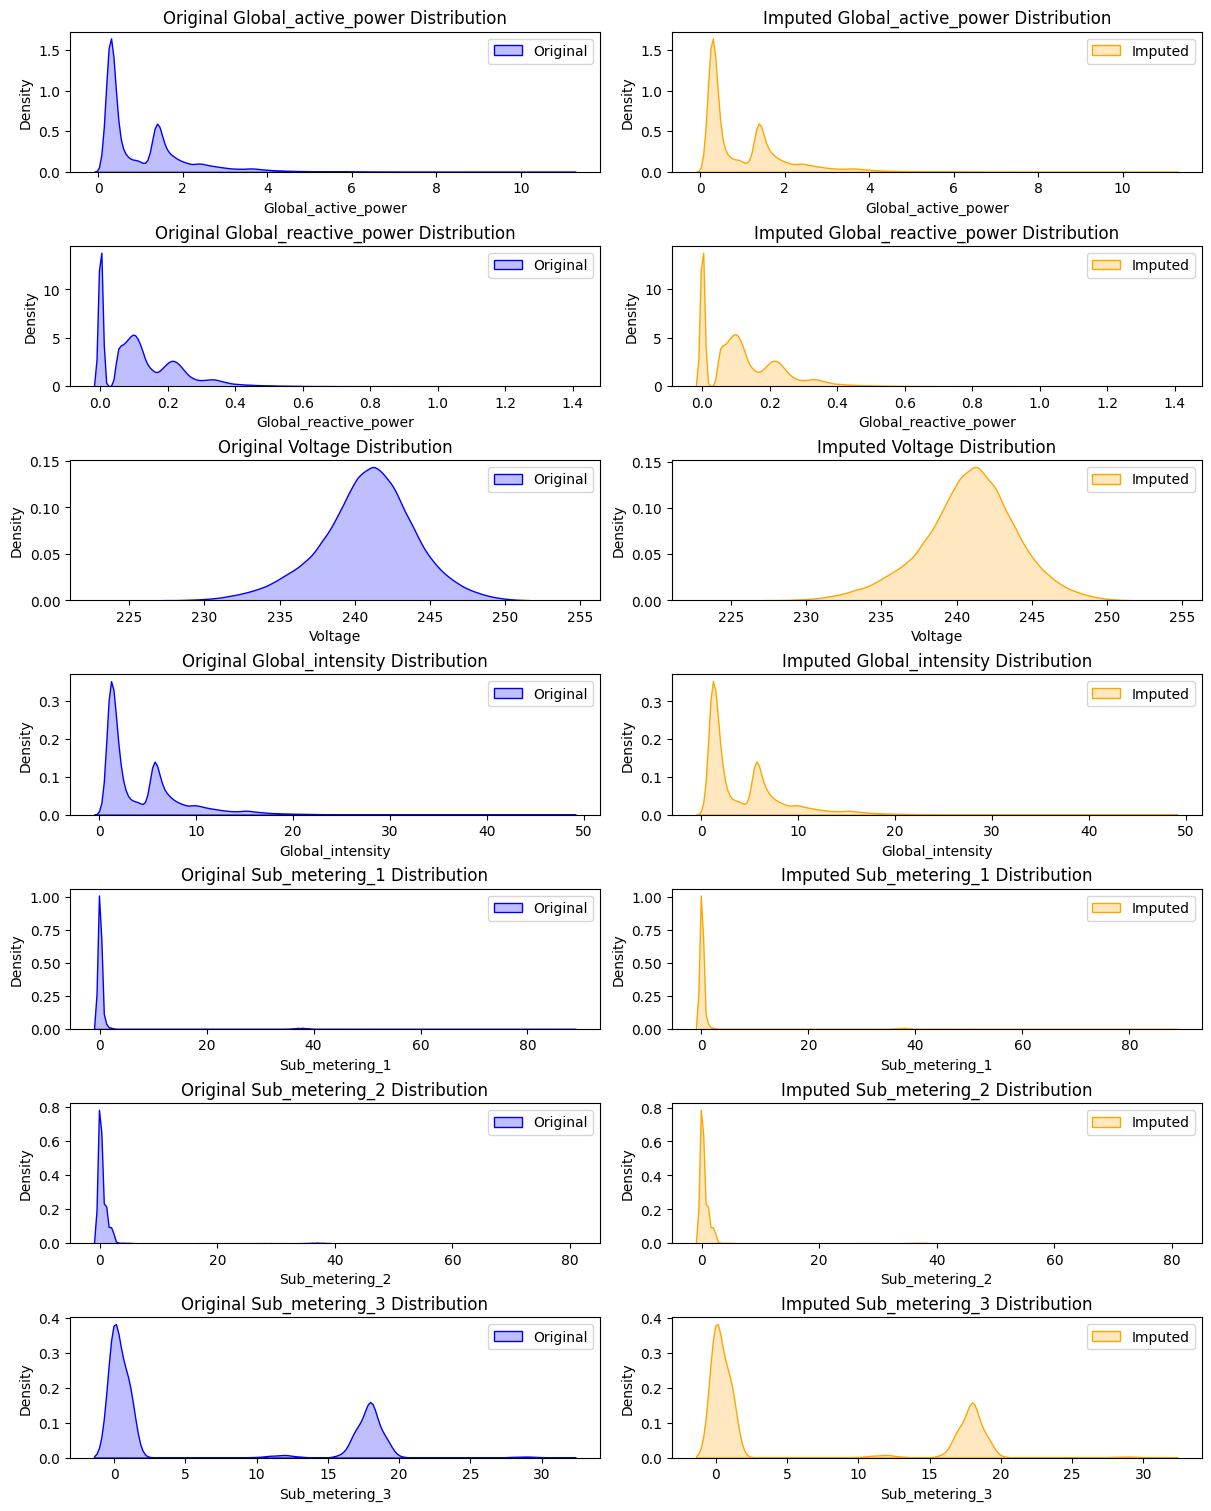

In [19]:
kdeplot(train_data, train_data_filled, feature_cols)

## Detect Outliers
- From the above plots we can see the outliers in the data
- cap the outliers using the IQR technique with the max and min values because the features are skewed
- As the data contains many factors depending on the time feature (seasons, holidays, some trends during days, ..) and after EDA the cap will be aggregated for each month, day of week, and hour.
- Handling the outliers in training data and leaving it in test data to see how the model will perform

In [20]:
# Get some date features for grouping before fill missing values
# Optimized function to get date features for grouping
def get_time_features(df, datetime_col):
    """
    Extracts hour, day of the week, and month from a datetime column.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        datetime_col (str): The name of the column containing datetime values.
    
    Returns:
        pd.DataFrame: The dataframe with new columns: 'day_of_week', 'hour', and 'month'.
    """
    # Extract date features
    df['minute'] = df[datetime_col].dt.minute         # Extract minute
    df['hour'] = df[datetime_col].dt.hour             # Extract hour directly
    df['day'] = df[datetime_col].dt.day
    df['day_of_week'] = df[datetime_col].dt.dayofweek  # 0: Monday, 1: Tuesday, ...
    df['month'] = df[datetime_col].dt.month           # Extract Months
    df['year'] = df[datetime_col].dt.year

    return df

# For train
train_data_filled = get_time_features(train_data_filled, 'Date')
# For test
test_data_filled = get_time_features(test_data_filled, 'Date')

In [21]:
class OutlierHandler:
    def __init__(self, group_columns, features, k=1.5):
        """
        Initialize the OutlierHandler.

        Parameters:
        group_columns (list): List of column names to group by.
        features (list): List of feature names to handle outliers for.
        k (float): The IQR multiplier to identify outliers (default is 1.5).
        """
        self.group_columns = group_columns
        self.features = features
        self.k = k
        self.thresholds = {}

    def compute_thresholds(self, df):
        """
        Compute outlier thresholds (lower and upper) using IQR for each group in the dataframe.

        Parameters:
        df (pd.DataFrame): The dataframe containing the features.

        Returns:
        None: The computed thresholds are stored in the class instance.
        """
        grouped = df.groupby(self.group_columns)
        for group_name, group in grouped:
            self.thresholds[group_name] = {}
            for feature in self.features:
                q1 = group[feature].quantile(0.10)
                q3 = group[feature].quantile(0.90)
                iqr = q3 - q1

                lower_threshold = q1 - self.k * iqr
                upper_threshold = q3 + self.k * iqr

                self.thresholds[group_name][feature] = (lower_threshold, upper_threshold)

    def apply_thresholds(self, df):
        """
        Apply precomputed outlier thresholds to a dataframe.

        Parameters:
        df (pd.DataFrame): The dataframe containing the features.

        Returns:
        pd.DataFrame: The dataframe with outliers replaced.
        """
        def replace_outliers(group):
            group_name = tuple(group[self.group_columns].iloc[0])
            if group_name in self.thresholds:
                for feature in self.features:
                    lower_threshold, upper_threshold = self.thresholds[group_name][feature]
                    group[feature] = group[feature].clip(lower=lower_threshold, upper=upper_threshold)
            return group

        # Apply thresholds to each group
        return df.groupby(self.group_columns, group_keys=False).apply(replace_outliers)


In [22]:
group_columns = ['month', 'day_of_week', 'hour']

# Initialize the OutlierHandler with the needed parameters
handler = OutlierHandler(group_columns=group_columns, features=feature_cols, k=1.5)
# Compute thresholds from the training data
handler.compute_thresholds(train_data_filled)
# Apply the thresholds to the training data
fianl_train = handler.apply_thresholds(train_data_filled)

# Feature Engineering:

In [50]:
def data_proccesed(df, columns):

    # Create target label the equation is ( global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) )
    df['total_energy'] = ((df['Global_active_power'] * 1000) / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

    # Lag features to put the values in minute 1 to predict the taget for minute 2 for the training data
    for feature in columns:
        df[f'Lag_{feature}'] = df[feature].shift(1)

    return df

In [ ]:
fianl_train = data_proccesed(fianl_train, feature_cols)
test_data_filled = data_proccesed(test_data_filled, feature_cols)

- There are 16 values in total energy equal 0 and this doesn't make any sense so I will fill this value with the average between the previous and after value

In [24]:
def fill_zero_with_avg(df, column):
    """
    Fills the zero values in the specified columns with the average of the previous and next values.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - columns (list): List of column names to process.

    Returns:
    - pd.DataFrame: DataFrame with zero values replaced by the average of previous and next values.
    """
    # Shift to get previous and next values
    prev_value = df[column].shift(1)
    next_value = df[column].shift(-1)
    
    # Calculate the average between the previous and next values where the current value is 0
    df[column] = df.apply(lambda row: (prev_value[row.name] + next_value[row.name]) / 2 
                      if row[column] == 0 else row[column], axis=1)
    
    return df


In [25]:
fianl_train = fill_zero_with_avg(fianl_train, 'total_energy')
test_data_filled = fill_zero_with_avg(test_data_filled, 'total_energy')

### Extract some features from date and time

In [26]:
# Define a function to categorize months into seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 0 # winter
    elif month in [3, 4, 5]:
        return 1 # spring
    elif month in [6, 7, 8]:
        return 2 # Summer
    elif month in [9, 10, 11]:
        return 3 # Fall

# Apply the function to create a season column
fianl_train['season'] = fianl_train['Date'].dt.month.apply(get_season)
test_data_filled['season'] = test_data_filled['Date'].dt.month.apply(get_season)


# Define public holidays in Paris
public_holidays = set(['01-01', '04-17', '05-01', '05-08', '05-25', '06-05', '07-14', '08-15', '11-01', '11-11', '12-25'])

# Define the function to check if the date is a public holiday or a weekend
def is_holiday(row):
    # Create a month-day string (e.g., '01-01' for January 1st)
    month_day = f"{row['month']:02d}-{row['day']:02d}"
    
    # Check if it's a public holiday or a weekend (Saturday=5, Sunday=6)
    if month_day in public_holidays or row['day_of_week'] in [5, 6]:  # 5: Saturday, 6: Sunday
        return 1
    return 0

# Apply the function to your DataFrame
fianl_train['holiday'] = fianl_train.apply(is_holiday, axis=1)
test_data_filled['holiday'] = test_data_filled.apply(is_holiday, axis=1)

In [27]:
# drop first record and useless features
fianl_train.drop(0, axis=0, inplace=True)
test_data_filled.drop(0, axis=0, inplace=True)

# drop original features
original_features = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']

fianl_train.drop(original_features, axis=1, inplace=True)
test_data_filled.drop(original_features, axis=1, inplace=True)

In [28]:
# Set 'Date' as index
fianl_train.set_index('Date', inplace=True)
test_data_filled.set_index('Date', inplace=True)

## EDA

#### Check features trend

In [29]:
def plot_features_boxplot(df, features, axis_range):
    """
    Plot box plots of features grouped by hours in subplots.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    features (list): List of feature names to plot.
    axis_range (str): Column name representing the axis range (hour, min, ..etc).

    Returns:
    None
    """
    # Determine the number of rows and columns for the subplot grid
    num_features = len(features)
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
    fig.tight_layout(pad=5.0)  # Adjust spacing between subplots

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each feature and plot the box plot in the corresponding subplot
    range = (df[axis_range].min(), df[axis_range].max())
    for i, feature in enumerate(features):
        sns.boxplot(x=df[axis_range], y=df[feature], ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature} by {axis_range}', fontsize=16)
        axes[i].set_xlabel(f'{axis_range} {range}', fontsize=14)
        axes[i].set_ylabel(feature, fontsize=14)
        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [30]:
# List features to plot
features_to_plot = ['total_energy', 'Lag_Global_active_power', 'Lag_Global_reactive_power', 'Lag_Voltage', 
                    'Lag_Global_intensity', 'Lag_Sub_metering_1', 'Lag_Sub_metering_2', 'Lag_Sub_metering_3']

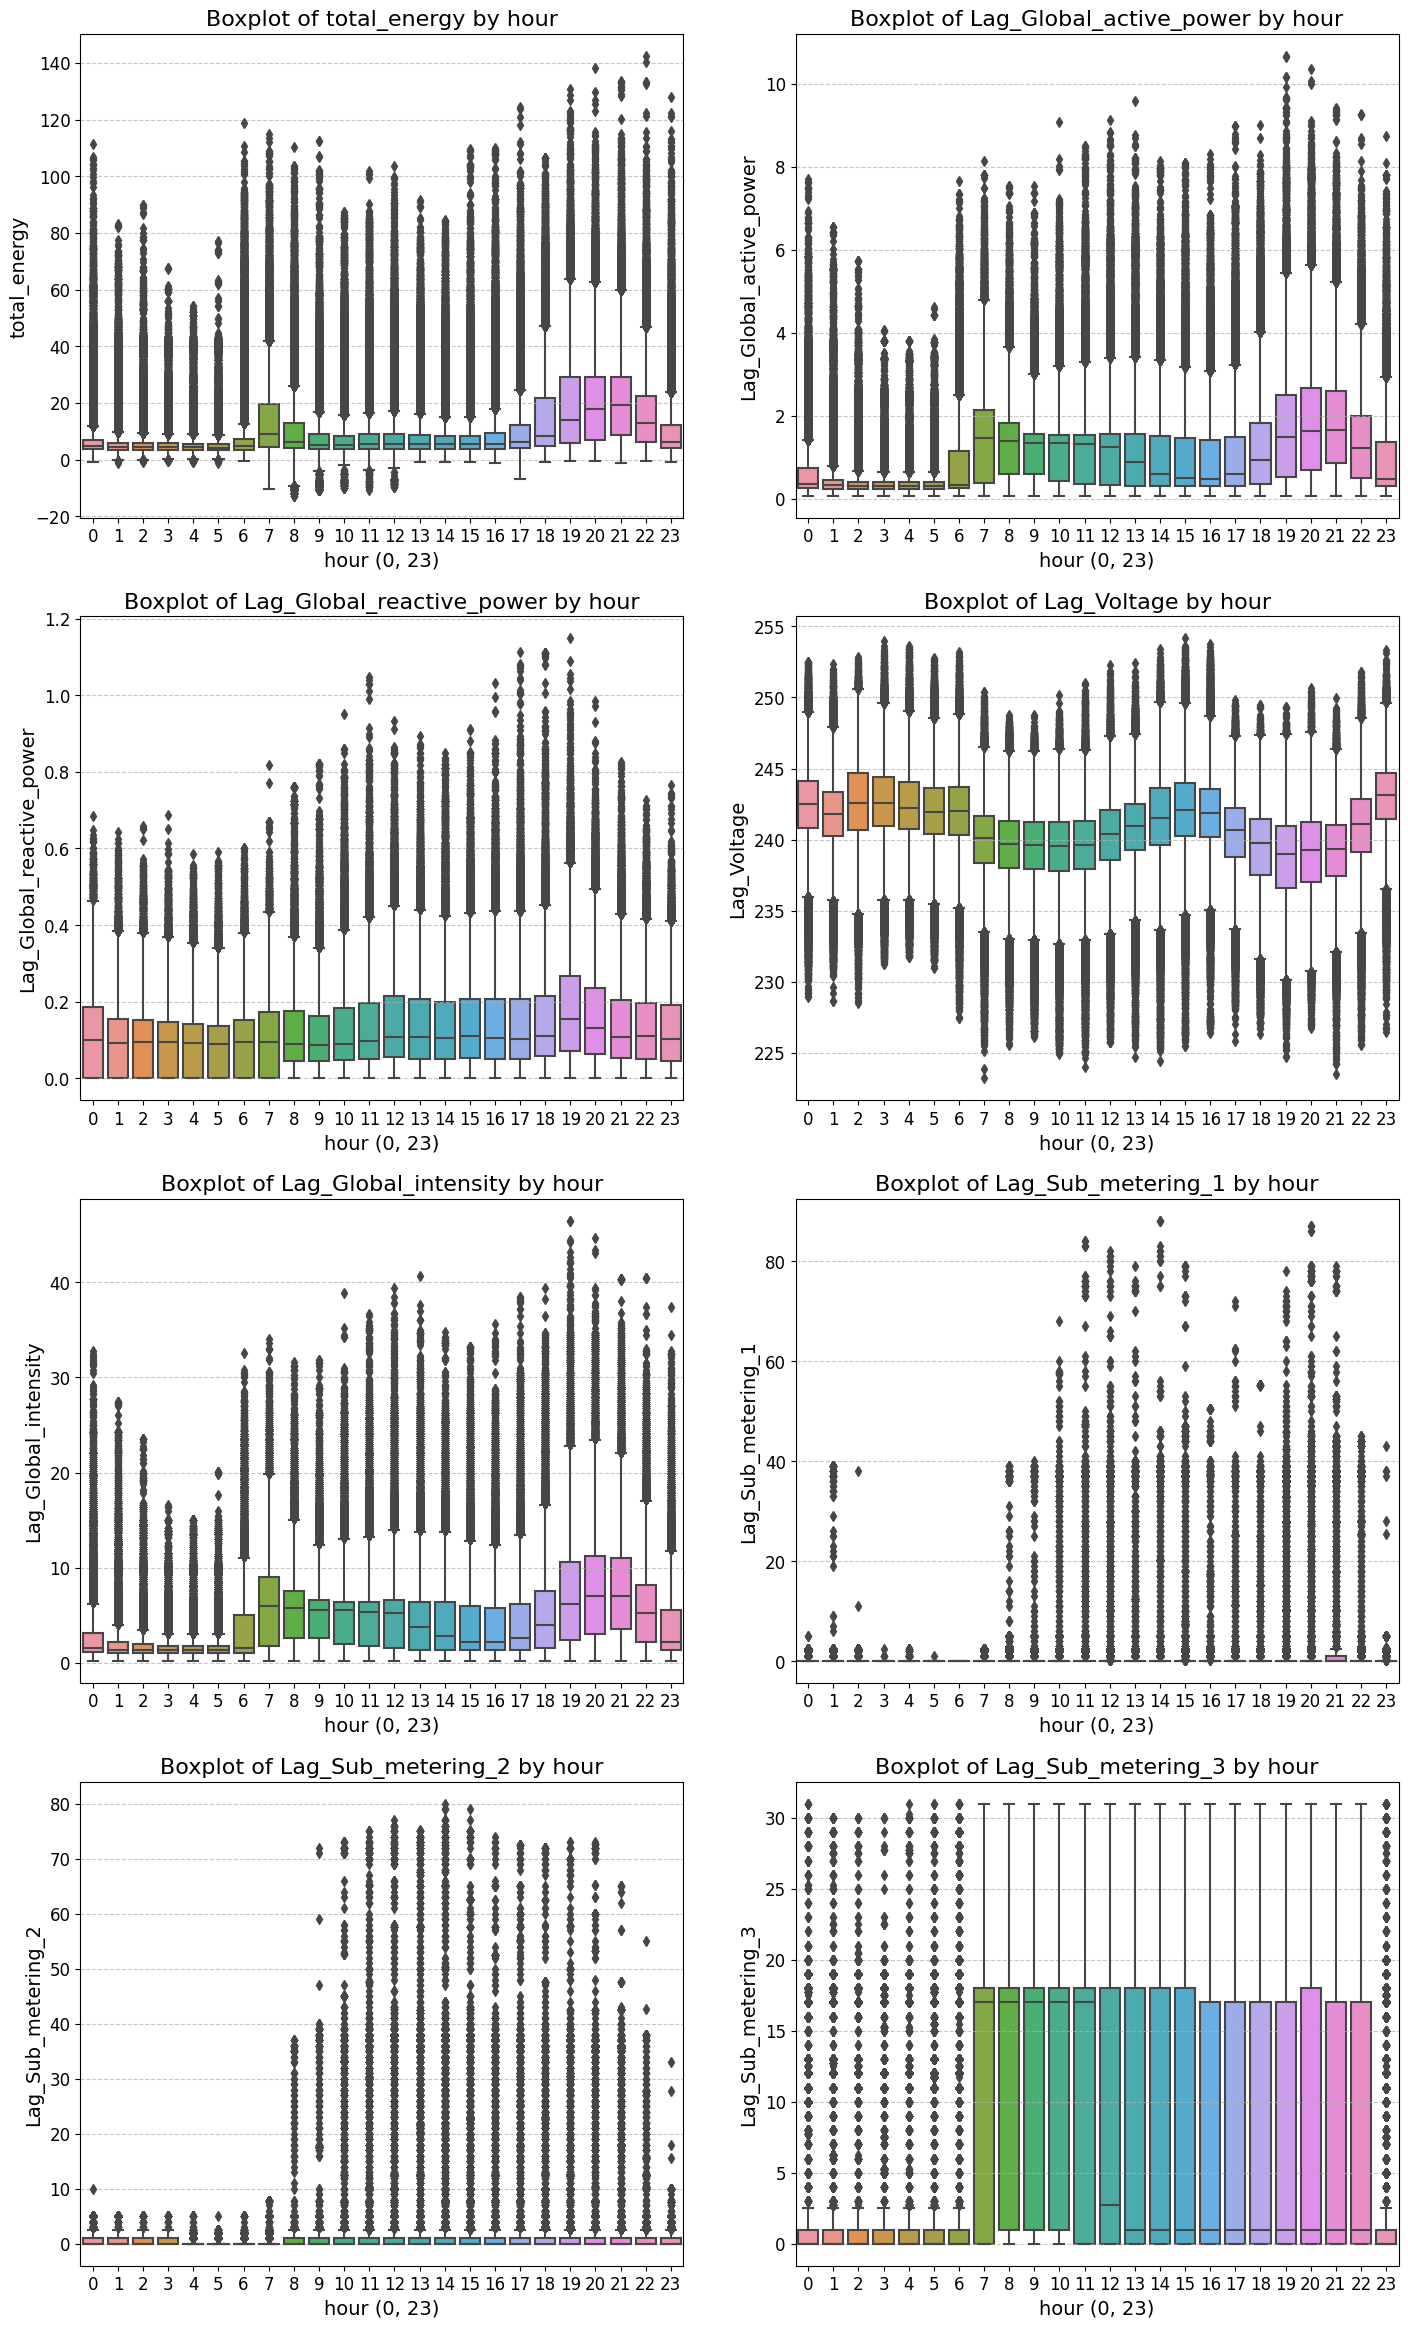

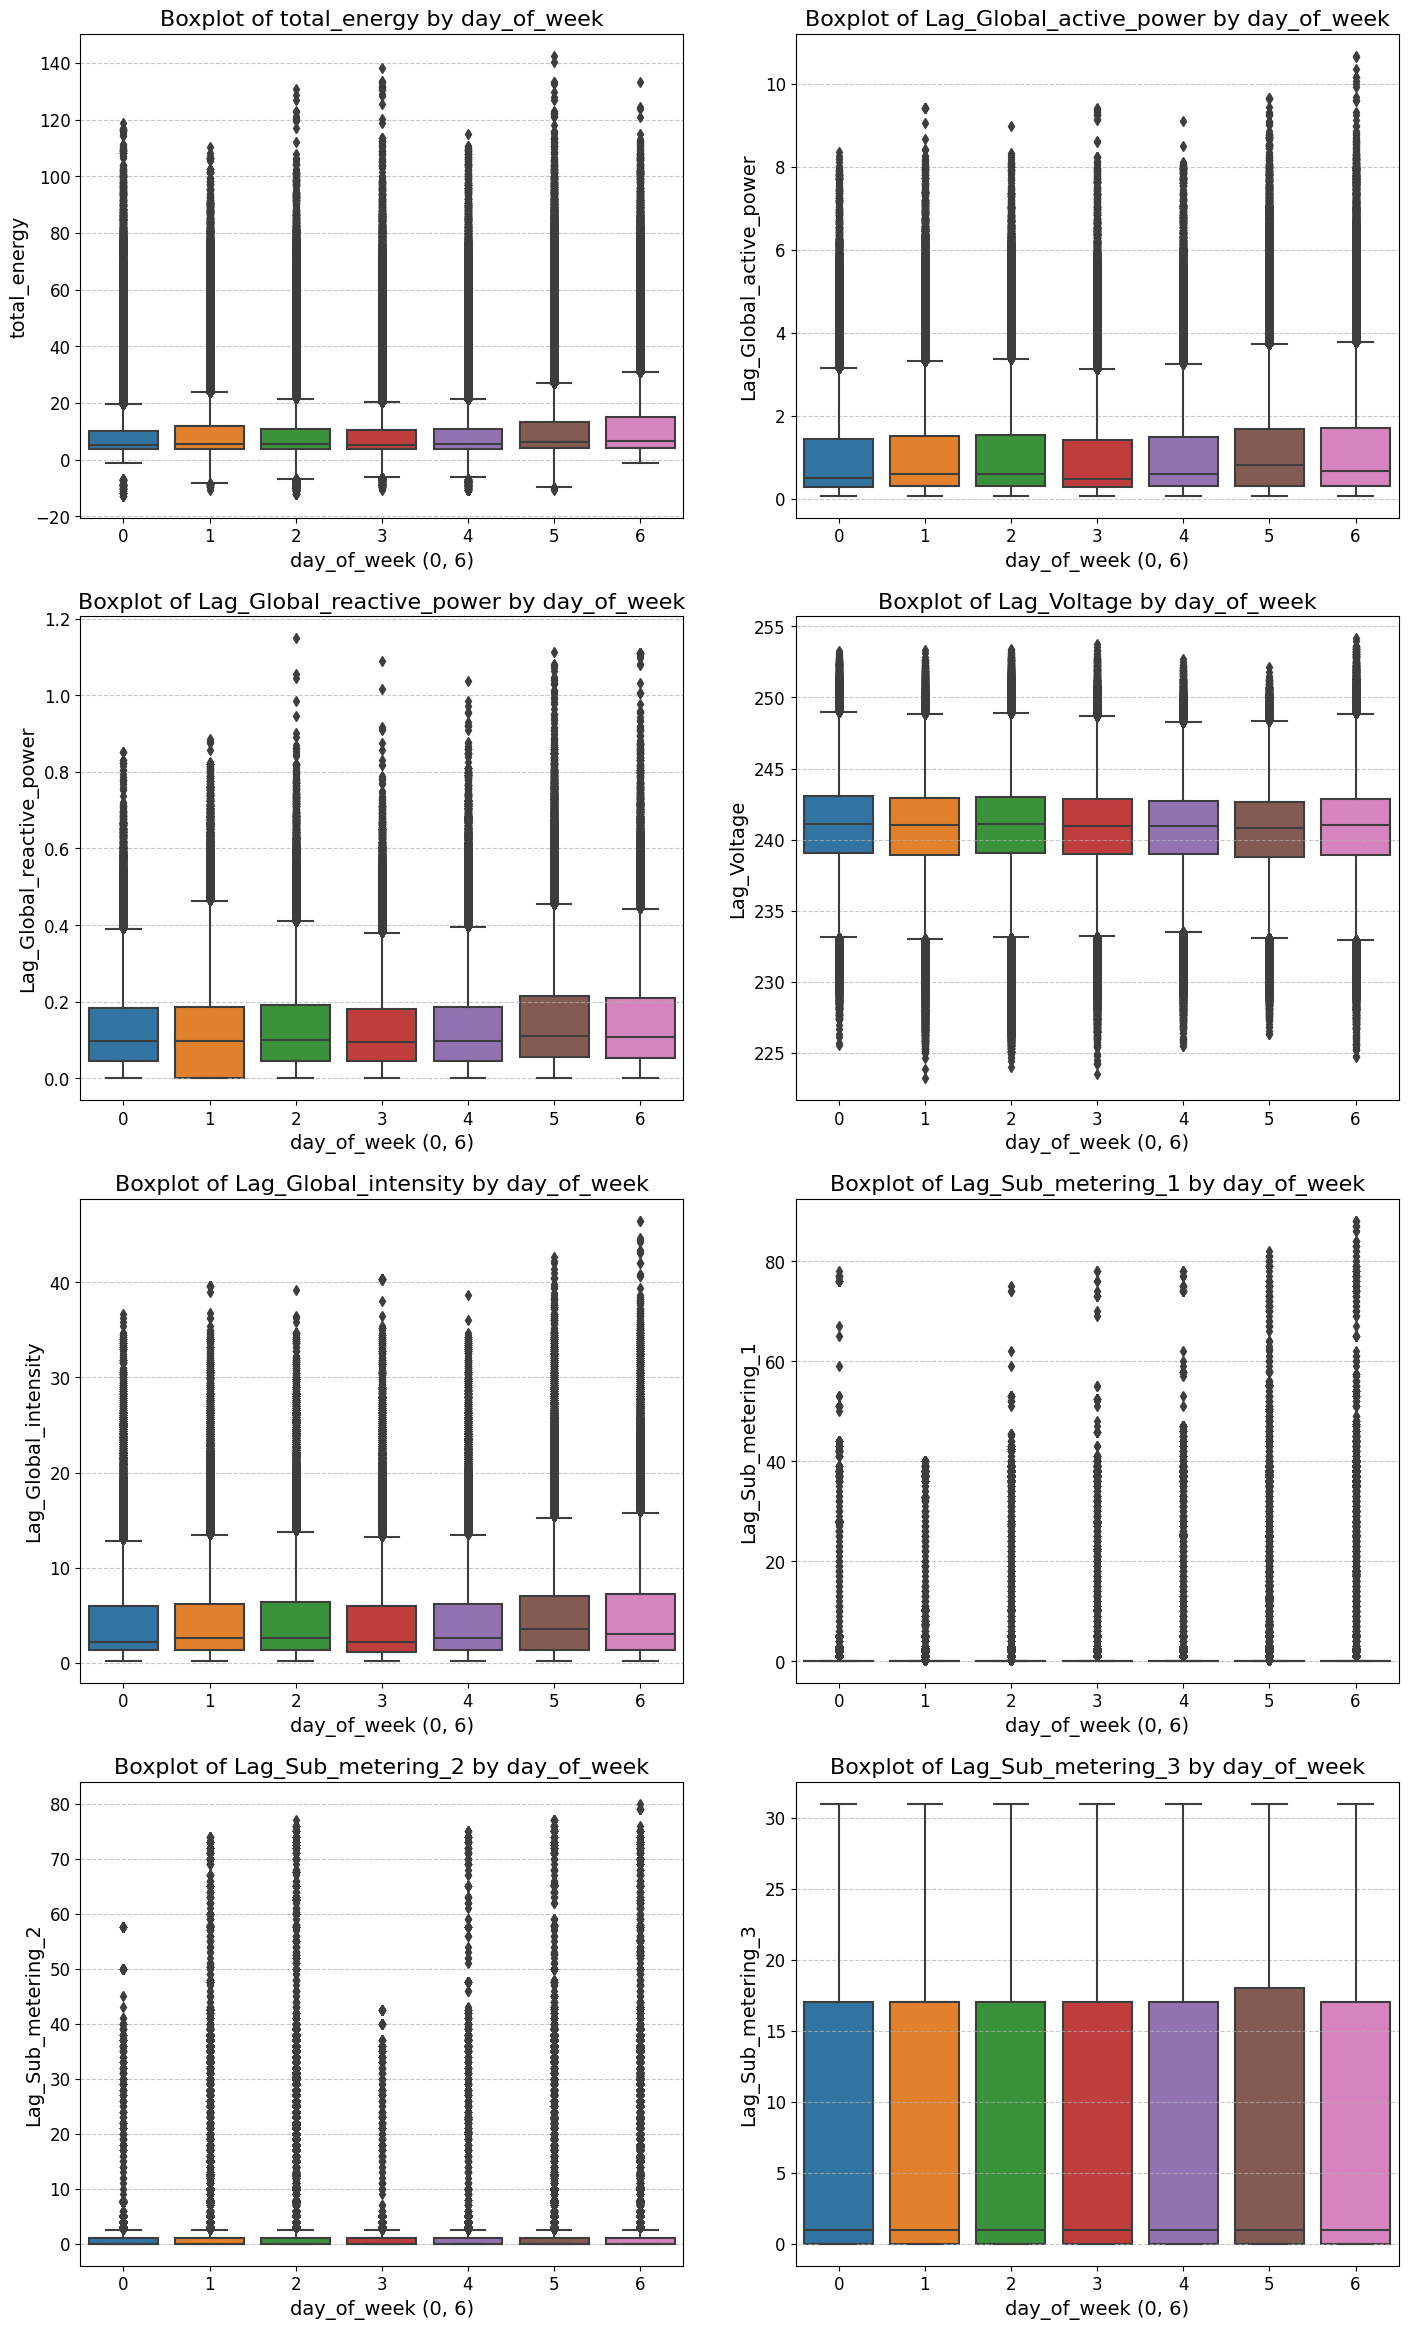

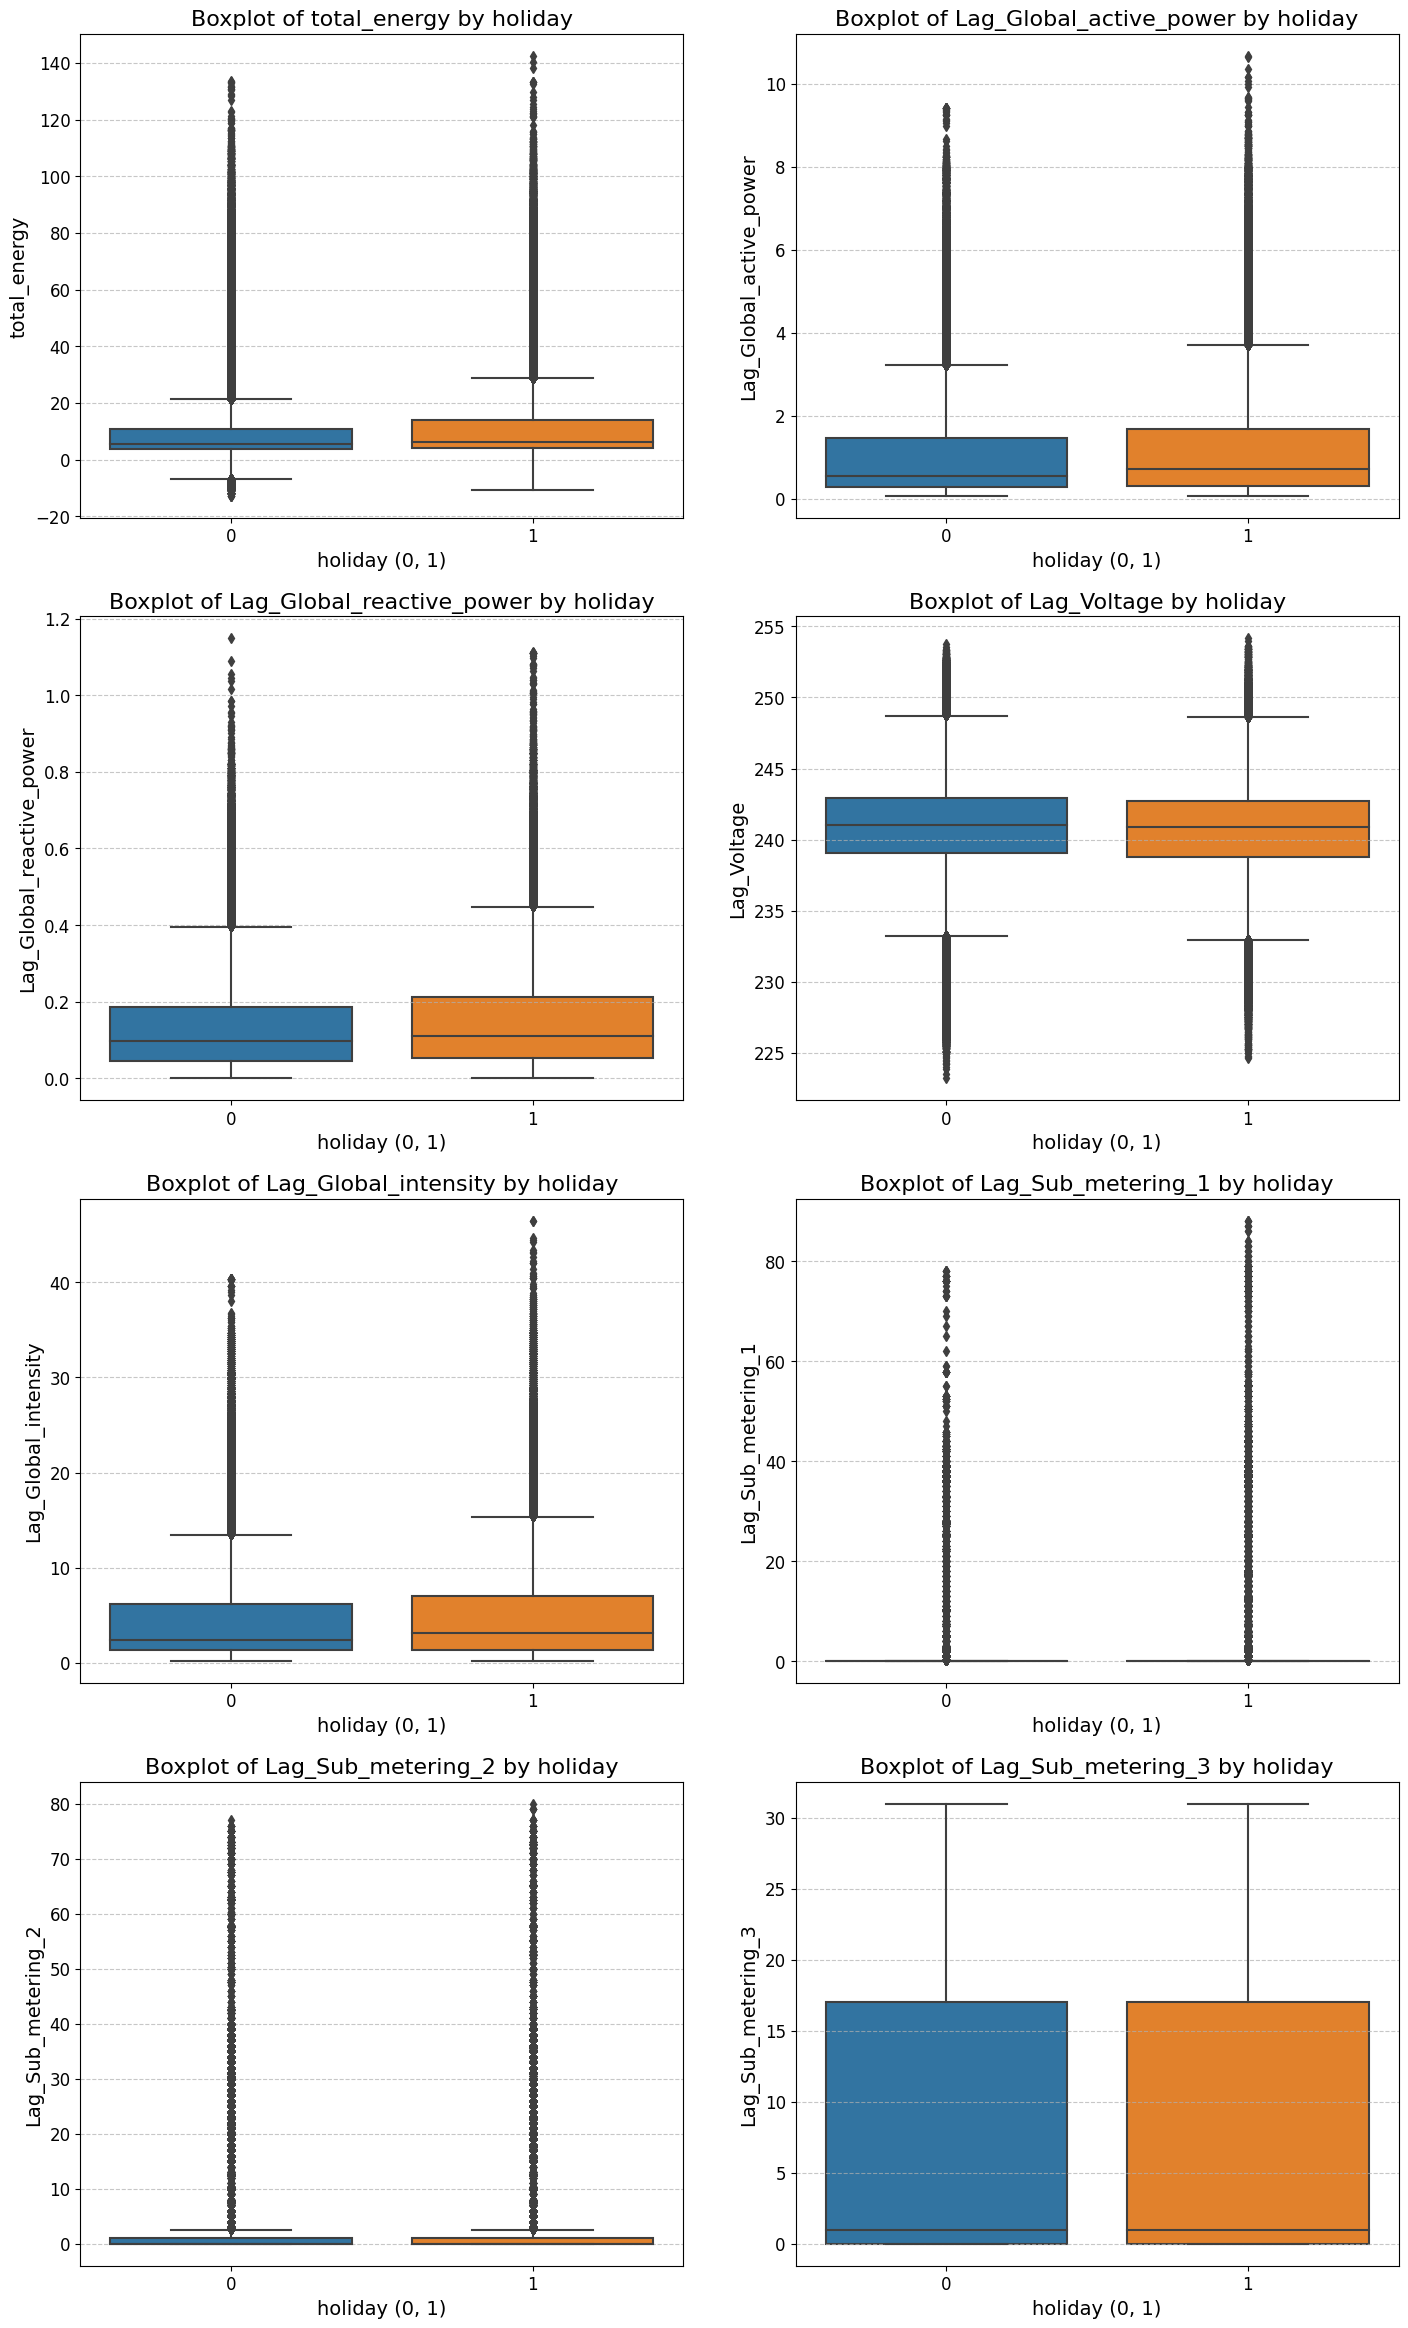

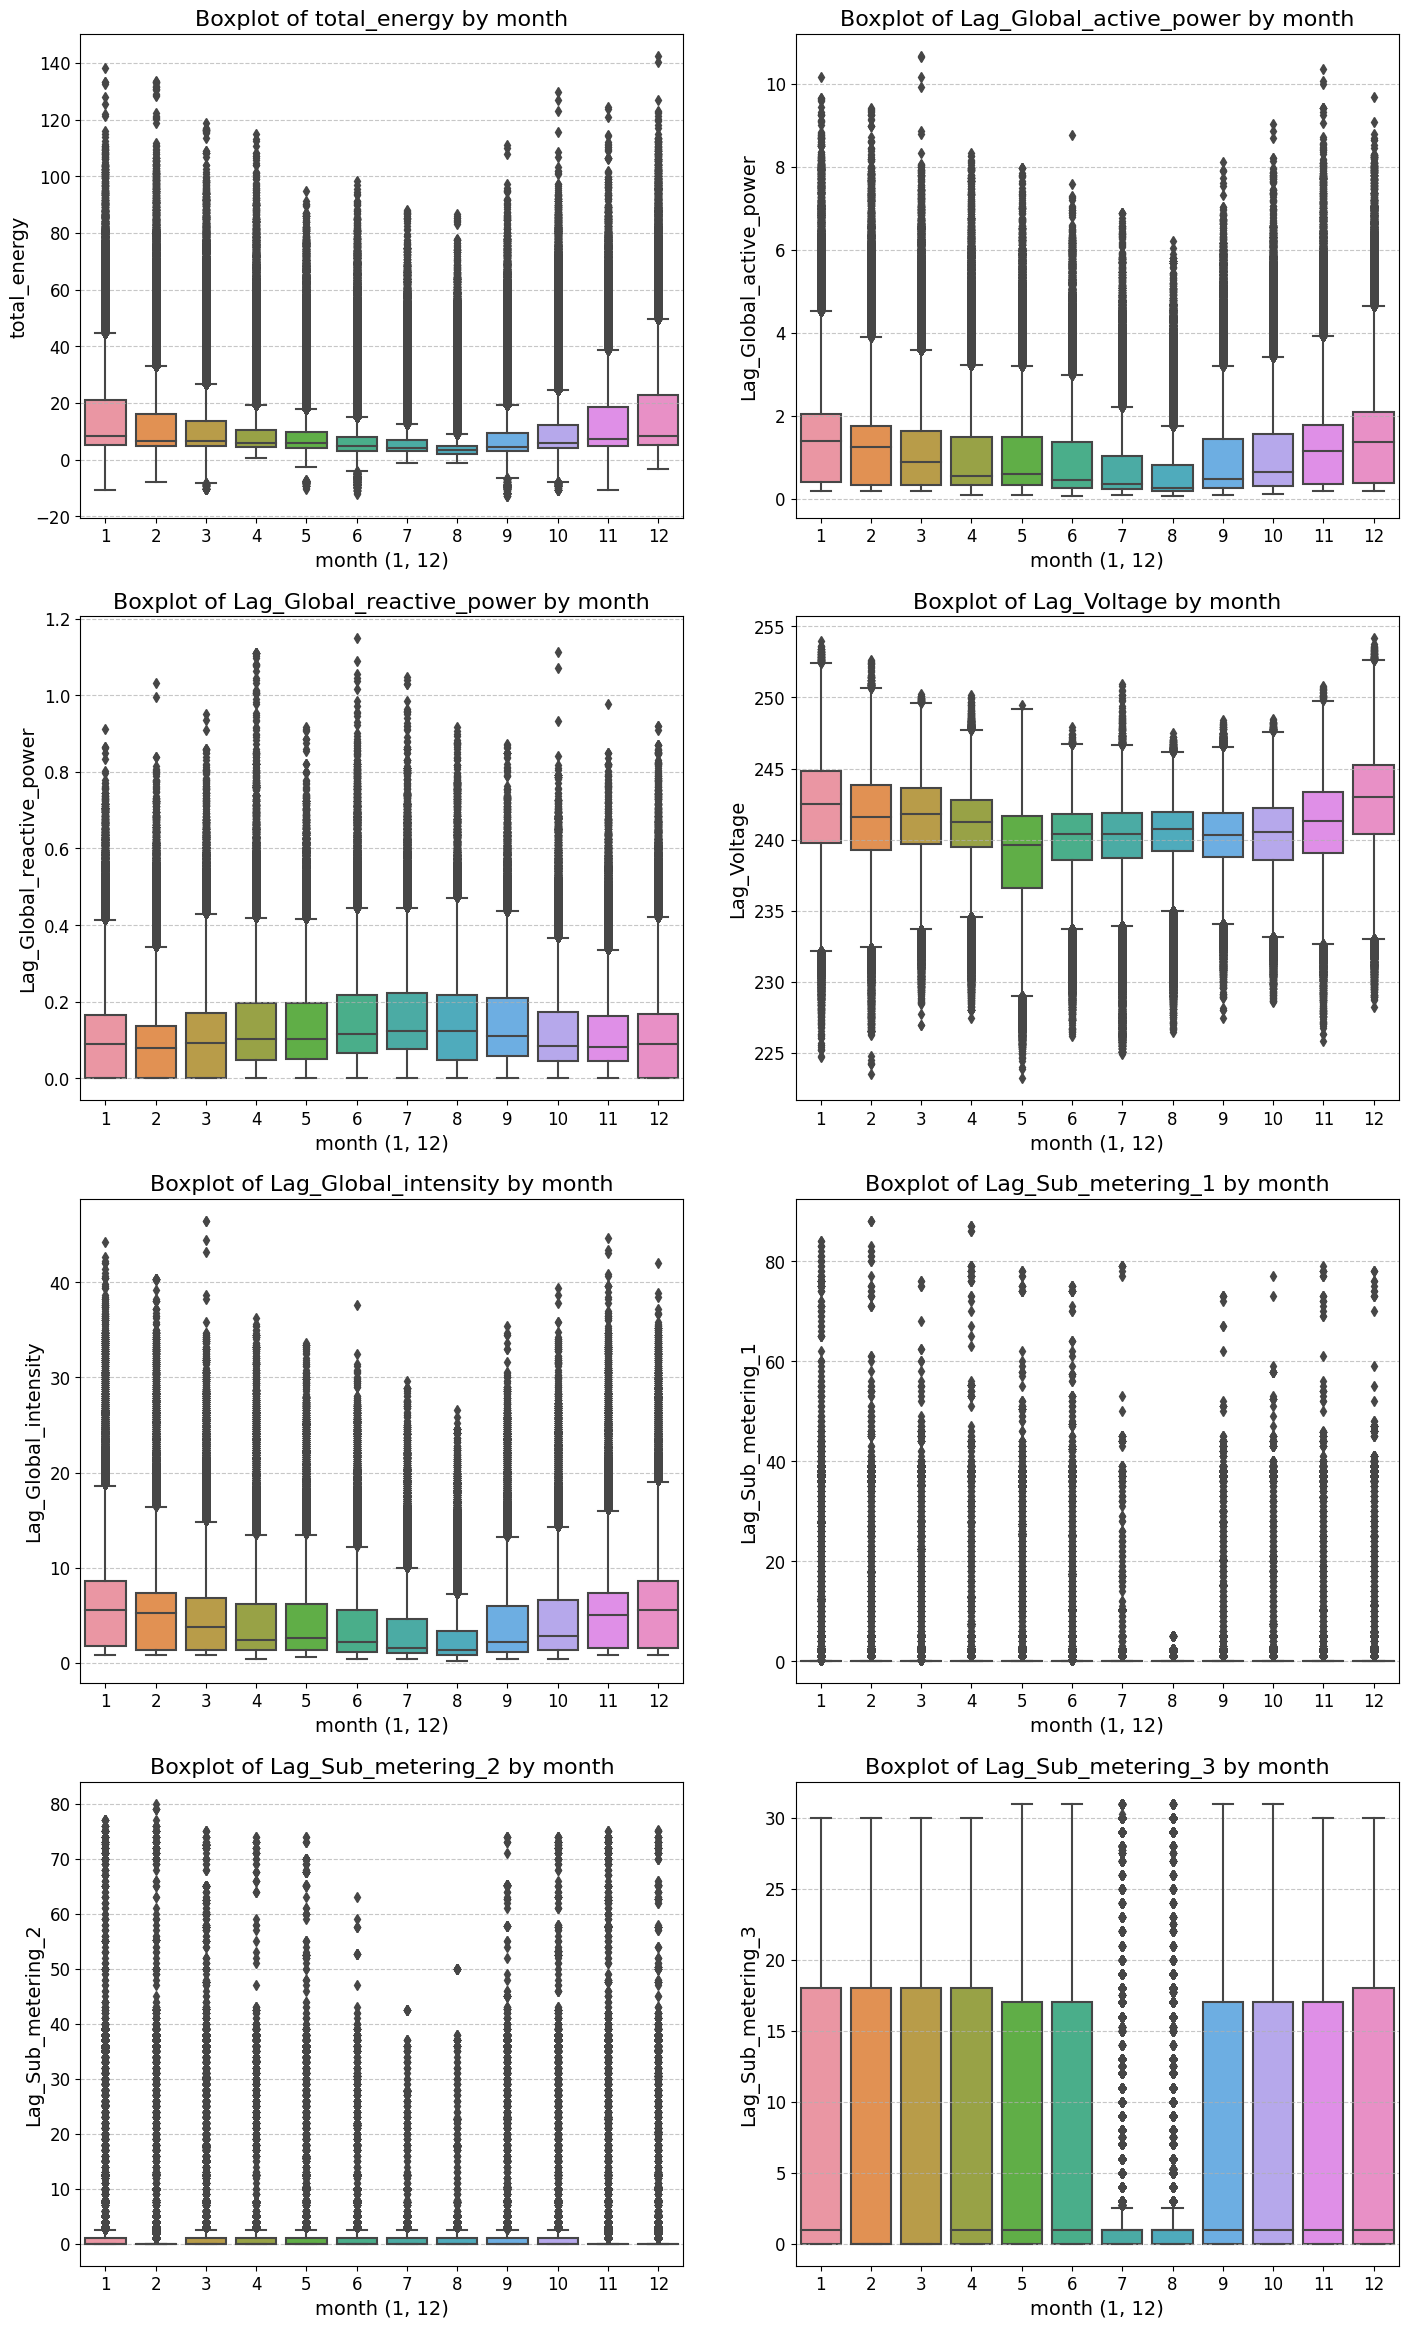

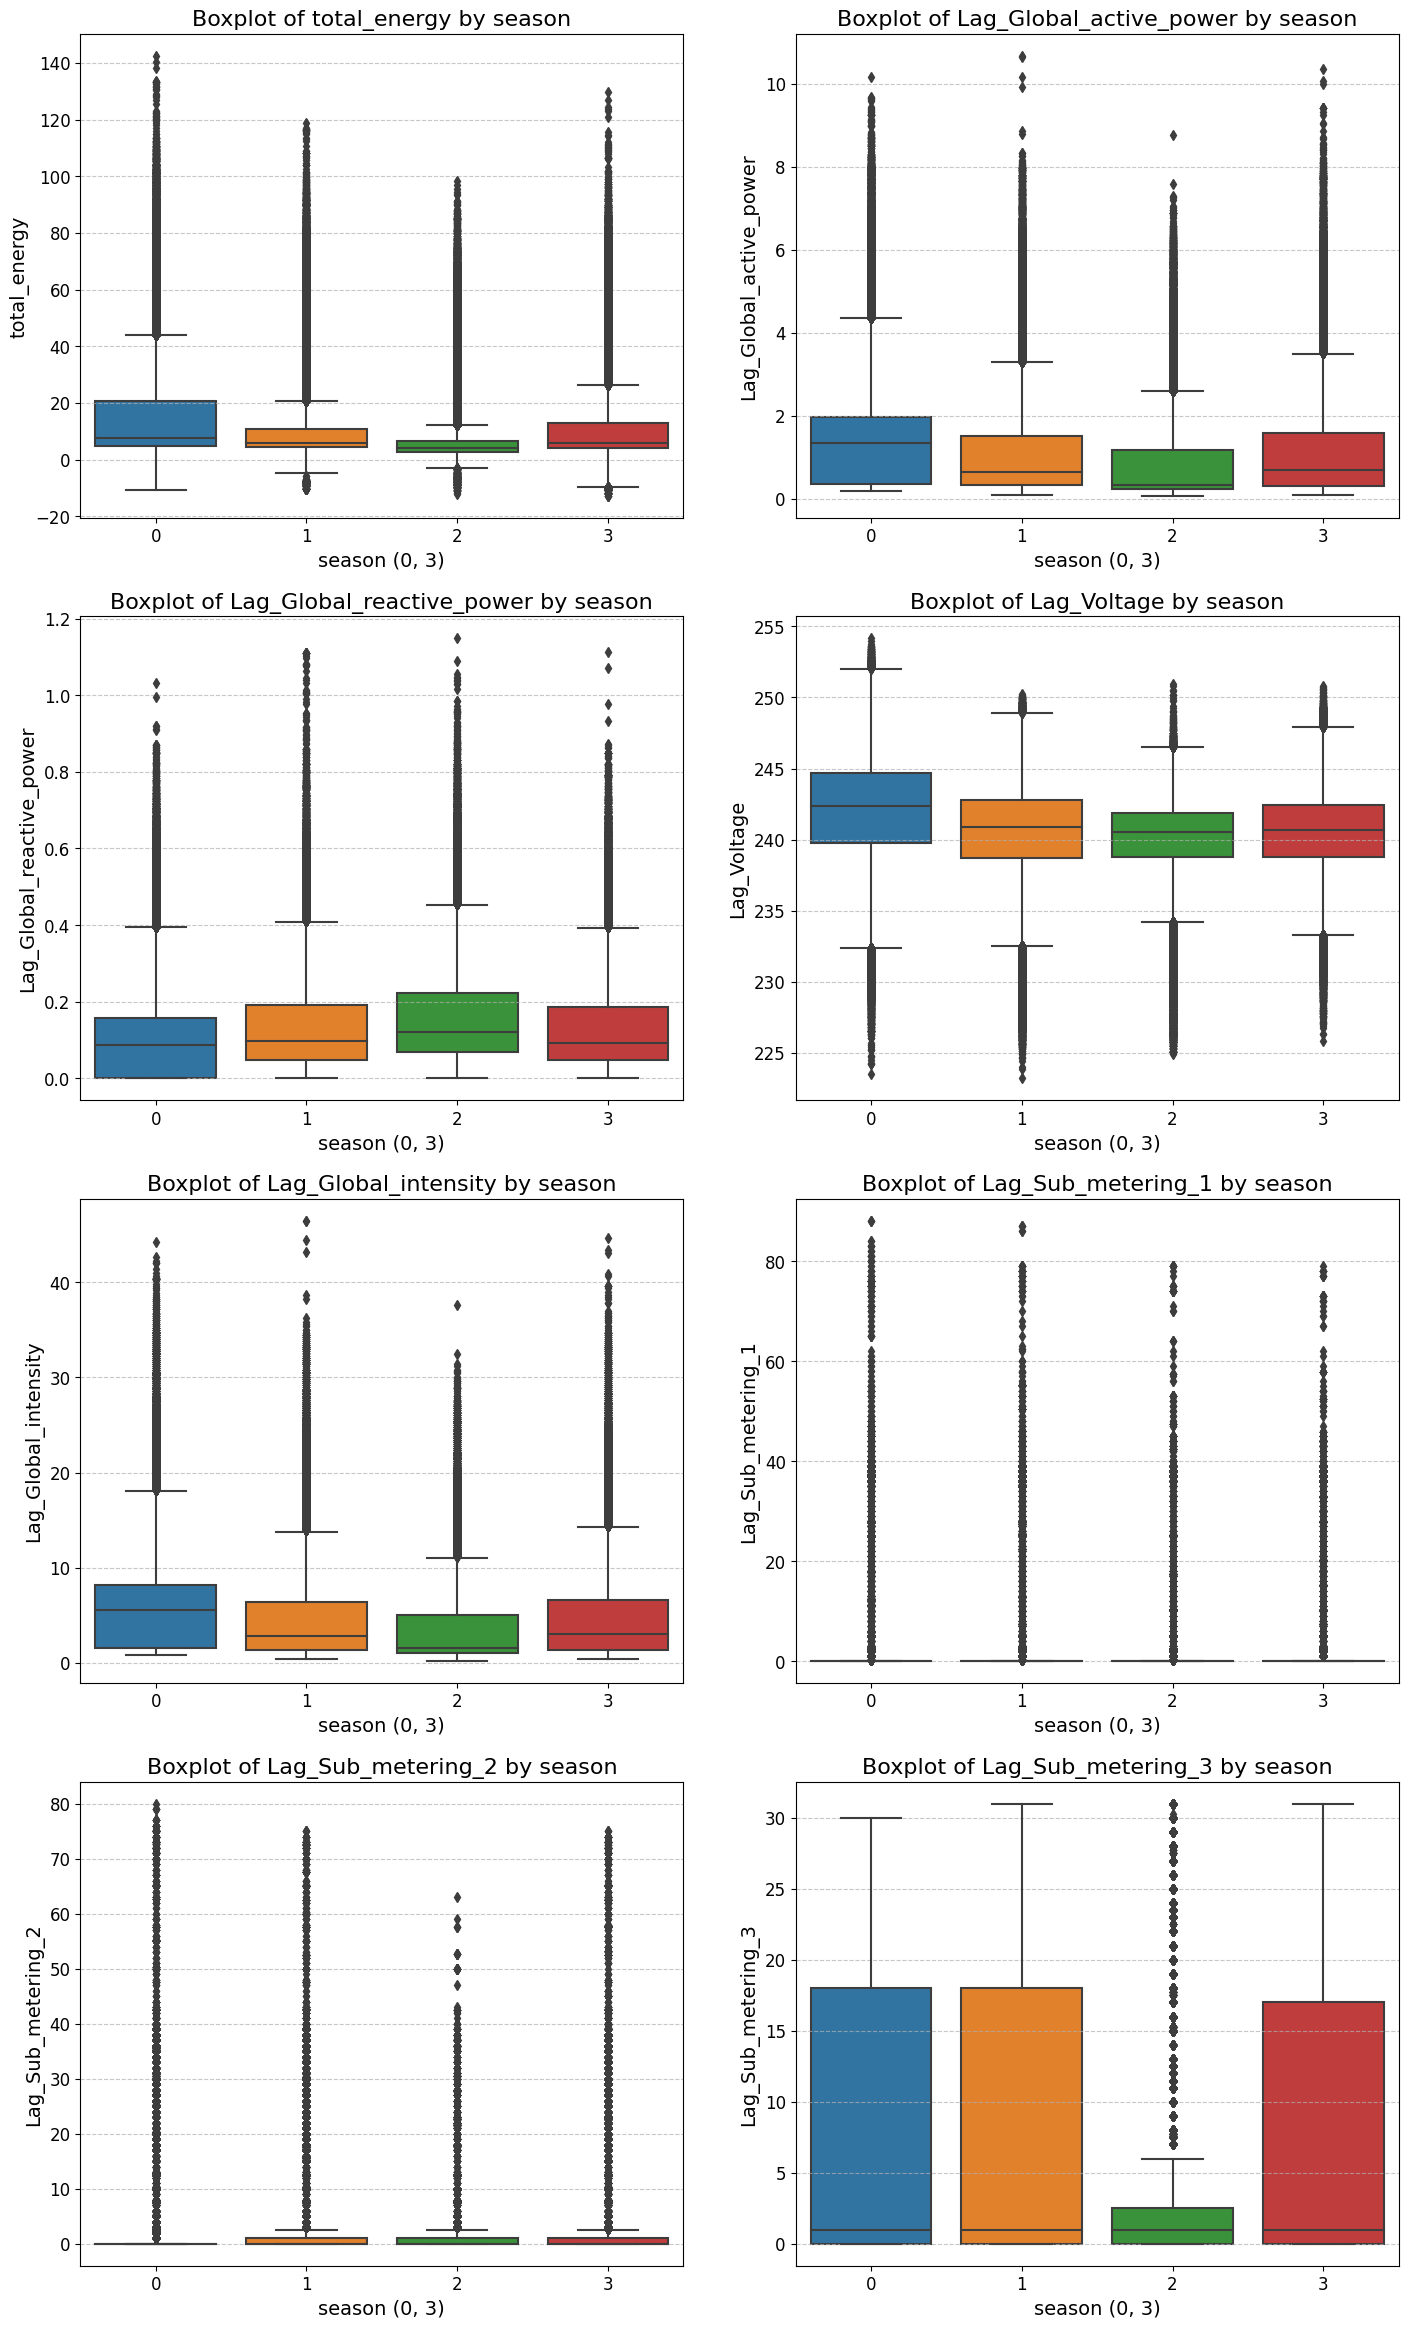

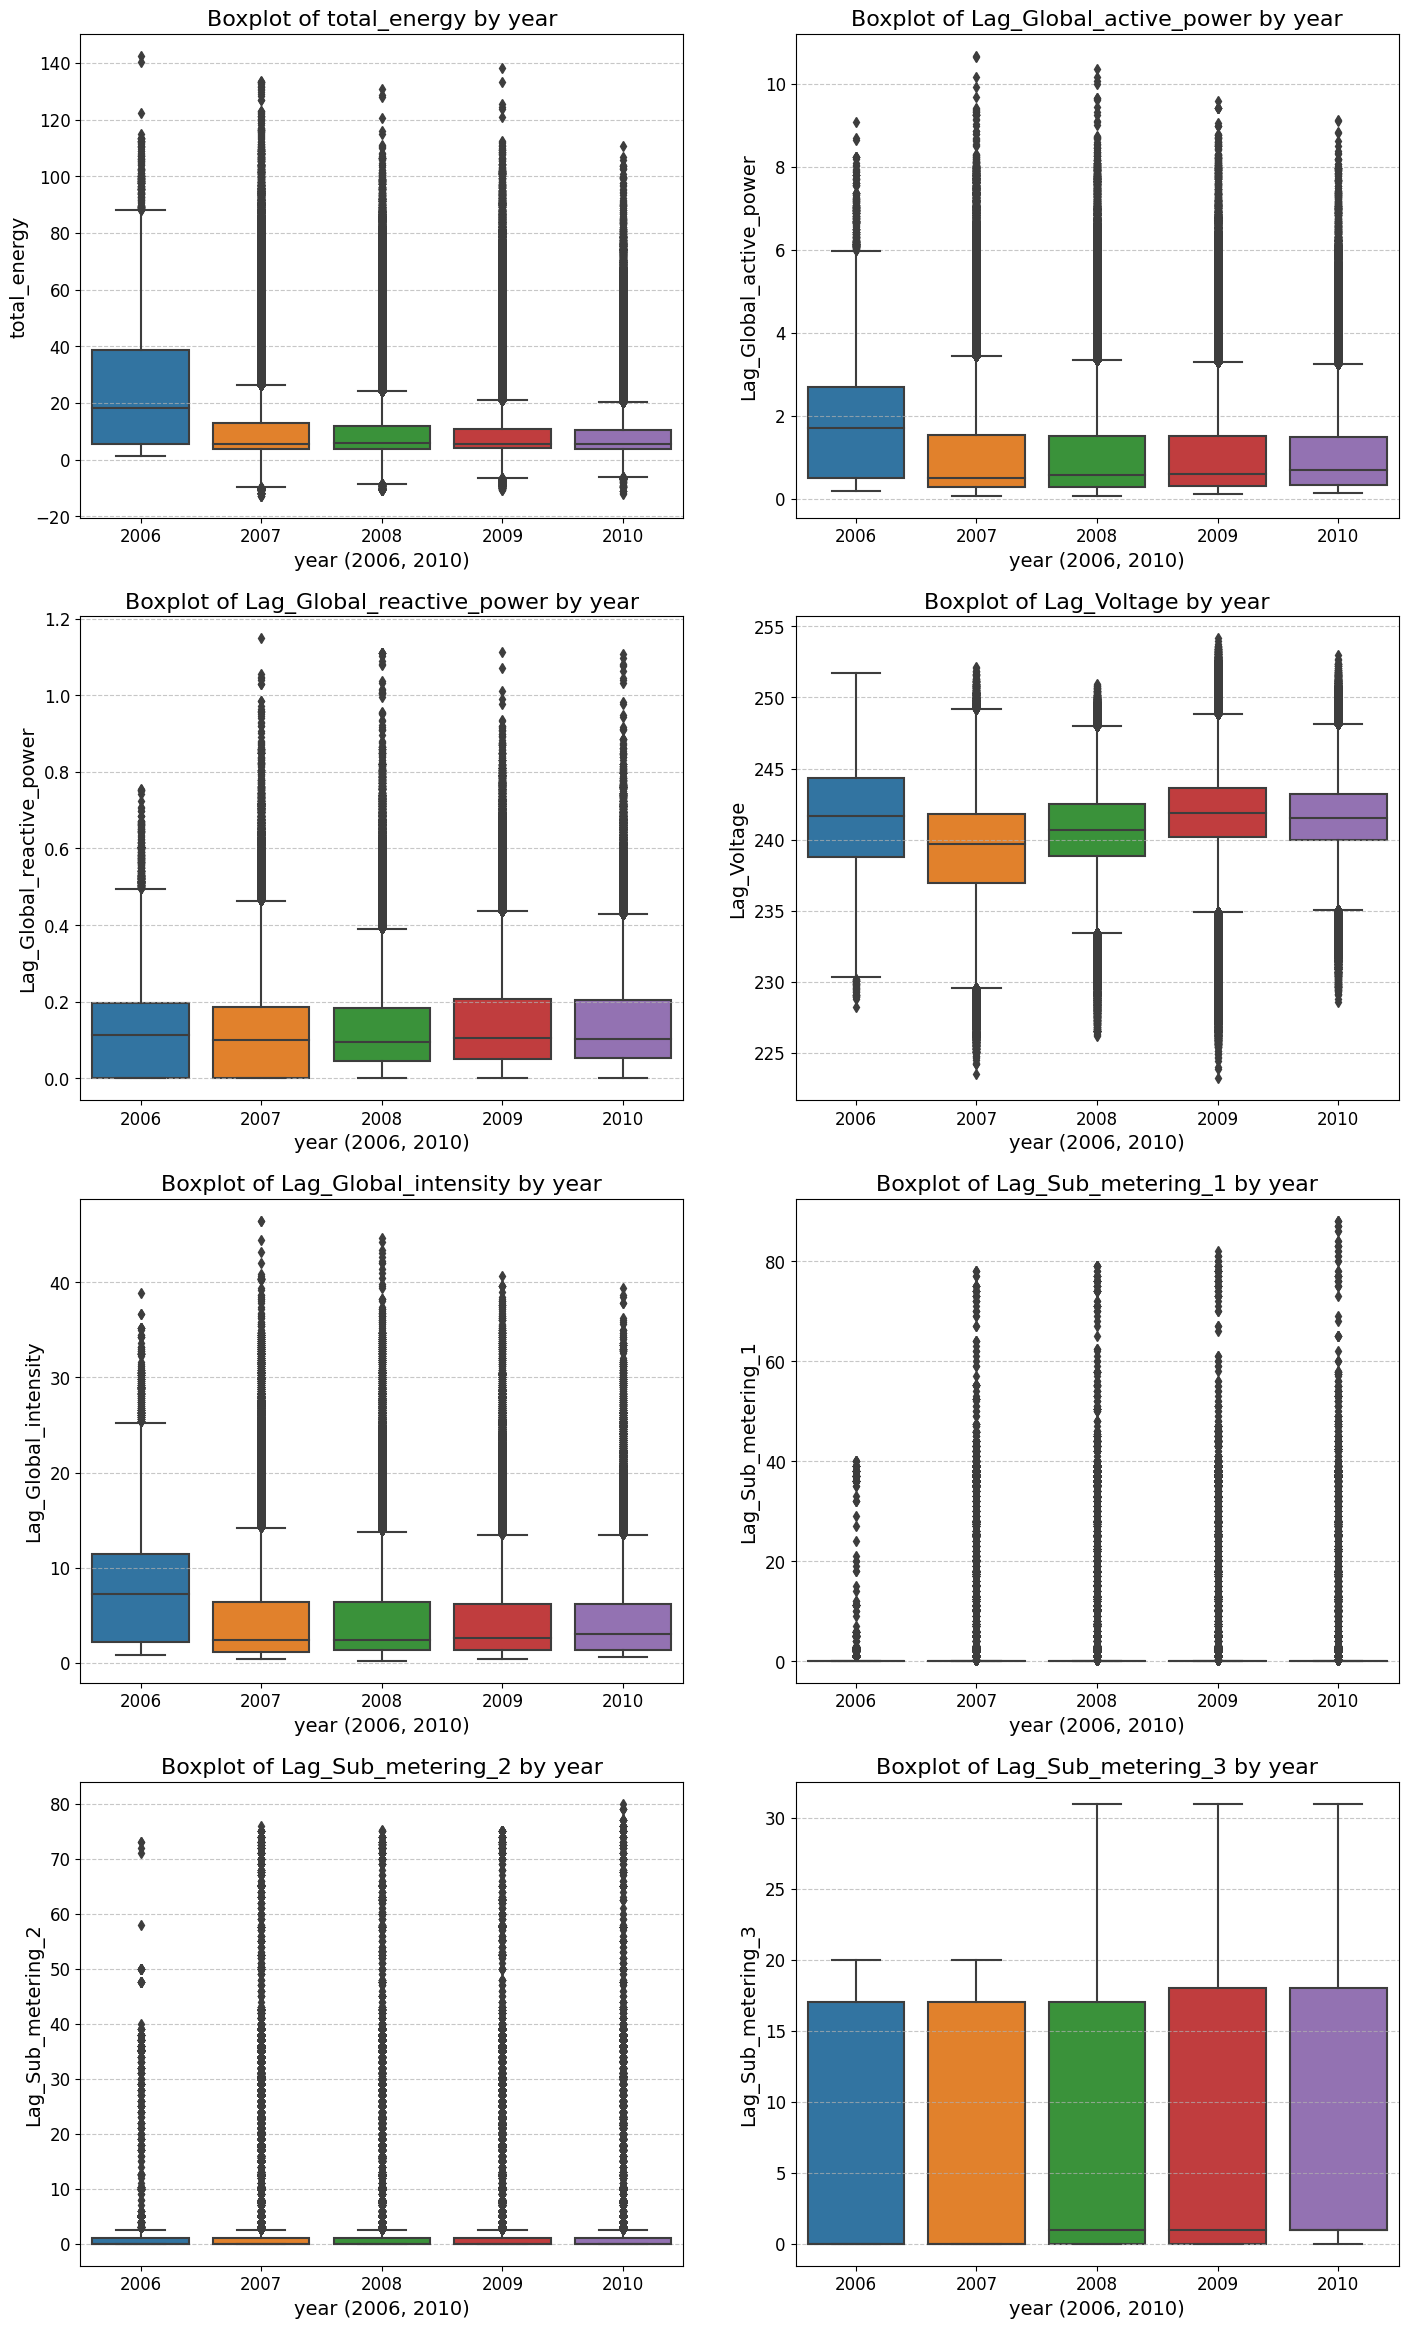

In [31]:
plot_features_boxplot(fianl_train, features_to_plot, 'hour')

plot_features_boxplot(fianl_train, features_to_plot, 'day_of_week')

plot_features_boxplot(fianl_train, features_to_plot, 'holiday')

plot_features_boxplot(fianl_train, features_to_plot, 'month')

plot_features_boxplot(fianl_train, features_to_plot, 'season')

plot_features_boxplot(fianl_train, features_to_plot, 'year')

- Apply same plots to ensure that the data is in same distribution between train and test

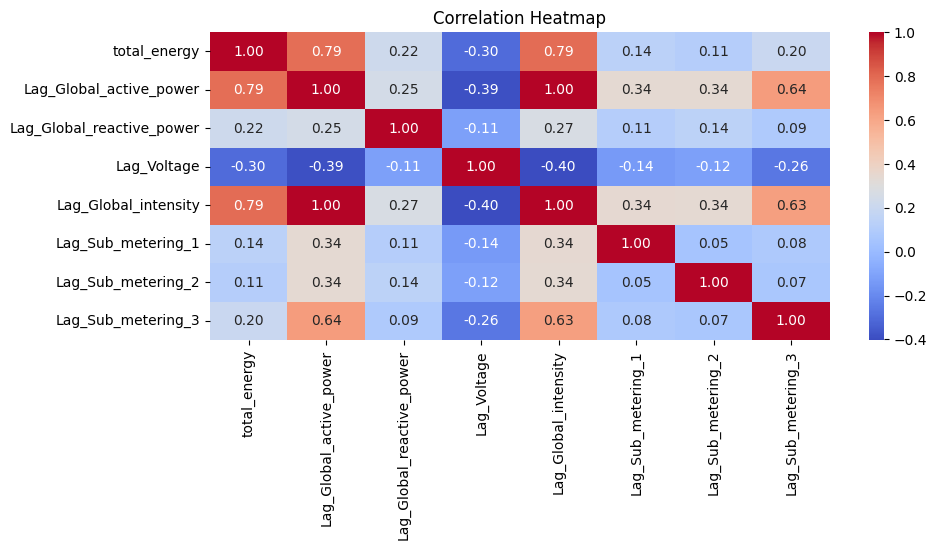

In [32]:
# Select numerical columns for correlation
numerical_columns = fianl_train.select_dtypes(include=['float64']).columns

# Calculate correlation matrix
corr_matrix = fianl_train[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

- Global_intensity and Global_active_power are highly correlated so remove one of them

In [33]:
fianl_train.drop('Lag_Global_intensity', axis=1, inplace=True)
test_data_filled.drop('Lag_Global_intensity', axis=1, inplace=True)

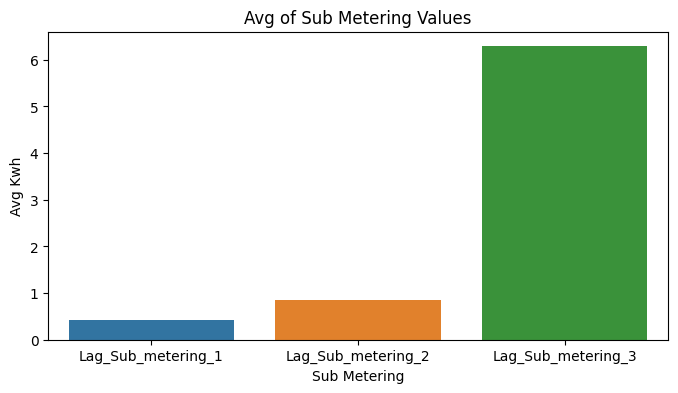

In [34]:
# Melt the DataFrame to long format for easier plotting
train_melted = fianl_train.melt(value_vars=['Lag_Sub_metering_1', 'Lag_Sub_metering_2', 'Lag_Sub_metering_3'], 
                          var_name='Sub_metering', 
                          value_name='Value')

# Create the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Sub_metering', y='Value', data=train_melted, estimator='mean', ci=None)
plt.title('Avg of Sub Metering Values')
plt.xlabel('Sub Metering')
plt.ylabel('Avg Kwh')
plt.show()

### Key Findings:

- Time of Day: Consumption peaks during early morning and evening hours, aligning with typical household activities.

- Seasonal Trends: 
    - Higher usage during winter due to heating needs.
    - Lower usage during summer specific in (August) due to most of people travel from cities to countryside in the summer holiday. (no peaks in summer because  most European households don’t have Air-Conditioning too)

- Holidays and Weekends: Electricity usage in the weekend and public holidays have higher energy usage but not that much, likely due to reduced activity in the household.

- Sub-metering: Different sub-metering categories (e.g., kitchen, laundry, water heating) show distinct usage patterns, with kitchen appliances contributing significantly to overall consumption.

- There is no any trend in specific minutes in the day



# Model Selection and Training:

- Based on the analysis we can notice that there is multicollinearity between some features and we have large data with high variance so, XGBoost is the best model but we will try some models as initial models to see the performance
- Note: Tree models have a downside when dealing with regression problems if the scale is becoming larger so, just ensure to monitor the model after the production stage.

In [35]:
# Prepare the data
X_train = fianl_train.drop(columns=['total_energy', 'year'], axis=1)
y_train = fianl_train['total_energy']

X_test = test_data_filled.drop(columns=['total_energy', 'year'], axis=1)
y_test = test_data_filled['total_energy']

## Try initial models

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
def calculate_mape(y, y_pred):
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    return mape

In [38]:
# List of models to evaluate
models = [
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    XGBRegressor,
]

# Model-specific parameters
model_params = {
    LinearRegression: {},
    DecisionTreeRegressor: {},
    RandomForestRegressor: {},
    XGBRegressor: {'objective': 'reg:squarederror', 'n_jobs': -1, 'verbosity': 1}
}

# Training loop
for model in models:
    print(f"\nTraining {model.__name__}...")
    initial_model = model(**model_params.get(model, {}))
    initial_model.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = initial_model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    print(f"Mean Absolute Error on Training Data: {train_mae:.4f}")
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    train_mape = calculate_mape(y_train, y_train_pred)
    print(f"MAPE of train: {train_mape:.2f}%")
    
    # Evaluate on testing data
    y_test_pred = initial_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    print(f"Mean Absolute Error on Testing Data: {test_mae:.4f}")
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    test_mape = calculate_mape(y_test, y_test_pred)
    print(f"MAPE of test: {test_mape:.2f}%")


Training LinearRegression...
Mean Absolute Error on Training Data: 1.5358
MAPE of train: 21.99%
Mean Absolute Error on Testing Data: 1.2393
MAPE of test: 19.60%

Training DecisionTreeRegressor...
Mean Absolute Error on Training Data: 0.0000
MAPE of train: 0.00%
Mean Absolute Error on Testing Data: 2.4392
MAPE of test: 32.67%

Training RandomForestRegressor...
Mean Absolute Error on Training Data: 0.5331
MAPE of train: 6.47%
Mean Absolute Error on Testing Data: 1.4050
MAPE of test: 21.70%

Training XGBRegressor...
Mean Absolute Error on Training Data: 1.4051
MAPE of train: 17.72%
Mean Absolute Error on Testing Data: 1.1840
MAPE of test: 18.05%


### Cross Validation and Hyper parameter tuning

In [39]:
# Timeall Series Split
tscv = TimeSeriesSplit(n_splits=2)

# XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:linear', random_state=42, n_jobs=-1)

# Define parameter search space for Bayesian Optimization
param_space = {
    'n_estimators': (50, 500),               # Range for the number of trees
    'max_depth': (3, 10),                     # Range for the tree depth
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Log-uniform sampling for learning rate
    'gamma': (0, 5),                          # Range for gamma (min loss reduction)
    'reg_lambda': (0.01, 10.0, 'log-uniform'),  # Regularization term (lambda)
    'reg_alpha': (0.01, 10.0, 'log-uniform')    # Regularization term (alpha)
}

# Create a custom scorer for MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Bayesian Optimization with Time Series Split
bayes_cv = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    cv=tscv,
    scoring=mae_scorer,
    n_iter=100,
    random_state=42,
    verbose=2
)

# Fit the model with cross-validation
bayes_cv.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END gamma=2, learning_rate=0.11883357504897696, max_depth=10, n_estimators=192, reg_alpha=1.0243393225105073, reg_lambda=0.17472534129202036; total time=  11.8s
[CV] END gamma=2, learning_rate=0.11883357504897696, max_depth=10, n_estimators=192, reg_alpha=1.0243393225105073, reg_lambda=0.17472534129202036; total time=  17.6s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END gamma=4, learning_rate=0.2017268796559709, max_depth=5, n_estimators=478, reg_alpha=3.9118639884156683, reg_lambda=0.015379379813713668; total time=   8.3s
[CV] END gamma=4, learning_rate=0.2017268796559709, max_depth=5, n_estimators=478, reg_alpha=3.9118639884156683, reg_lambda=0.015379379813713668; total time=  19.2s
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END gamma=2, learning_rate=0.22754356809600707, max_depth=4, n_estimators=245, reg_alpha=0.036632415719891995, reg_lambda=0.2296127666011783; total time=   

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, im...
                                     n_jobs=-1, num_parallel_tree=None,
                                     objective='reg:linear', ...),
              n_iter=100, random_state=42,
              scoring=make_scorer(mean_absolute_error, greater_is_better=False),
              search_spaces={'gamma': (0, 5),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (50, 500),
                             'reg_alpha': (0.01, 10.0, 'log-uniform'),
                             'reg_lambda': (0.01, 10.0, 'log-uniform')},
              verbose=2)

In [40]:
# Best parameters and performance
print("Best Parameters:", bayes_cv.best_params_)
print("Best MAE Score:", -bayes_cv.best_score_)  # Negate the score since MAE is minimized

Best Parameters: OrderedDict([('gamma', 5), ('learning_rate', 0.06286169380762291), ('max_depth', 5), ('n_estimators', 426), ('reg_alpha', 0.01), ('reg_lambda', 10.0)])
Best MAE Score: 1.5214415234736558


In [41]:
# Get best model
best_model = bayes_cv.best_estimator_

## Model Evaluation:

In [47]:
# Evaluate training data
y_train_pred = best_model.predict(X_train)
mse = mean_absolute_error(y_train, y_train_pred)
print("Mean abs Error on Training Data:", mse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
print(f"MAPE of train: {mape:.2f}%")

Mean abs Error on Training Data: 1.4148963401742245
MAPE of train: 17.90%


In [48]:
# Evaluate test data
y_test_pred = best_model.predict(X_test)
test_mse = mean_absolute_error(y_test, y_test_pred)
print("Mean abs Error on Testing Data:", test_mse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f"MAPE of test: {mape:.2f}%")

Mean abs Error on Testing Data: 1.1651204535495985
MAPE of test: 18.09%


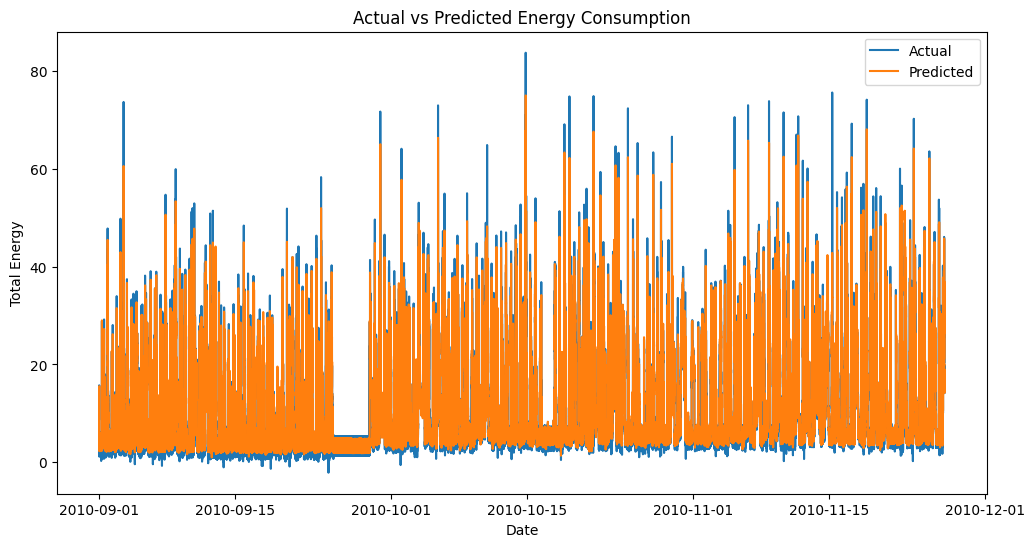

In [44]:
# Plot actual vs predicted values in Training data
plt.figure(figsize=(12, 6))
plt.plot(test_data_filled.index, y_test, label='Actual')
plt.plot(test_data_filled.index, y_test_pred, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Total Energy')
plt.legend()
plt.show()

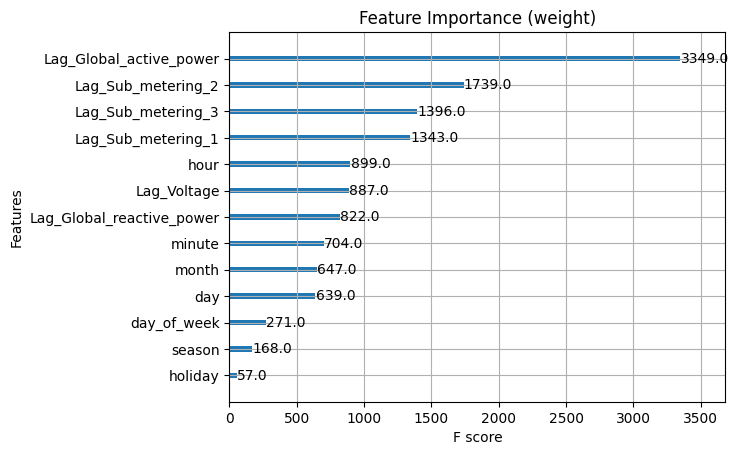

In [45]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Extract feature importance
feature_importance = best_model.get_booster().get_score(importance_type='weight')

# Sort feature importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plot feature importance
xgb.plot_importance(best_model, importance_type='weight', title="Feature Importance (weight)")
plt.show()

## Train the model in the entire dataset

In [56]:
## Prepare entire data

# fill missing values
df = fill_missing_same_minute(df, 'Date', feature_cols)

# get time features (day of week, months, ..)
df = get_time_features(df, 'Date')

# Initialize the OutlierHandler with the needed parameters
df_handler = OutlierHandler(group_columns=group_columns, features=feature_cols, k=1.5)
# Compute thresholds from the training data
df_handler.compute_thresholds(df)
# Apply the thresholds to the training data
fianl_df = df_handler.apply_thresholds(df)

# create target and lag features
fianl_df = data_proccesed(fianl_df, feature_cols)

# fill zero values in the target
fianl_df = fill_zero_with_avg(fianl_df, 'total_energy')

# computer season and holidays
fianl_df['season'] = fianl_df['Date'].dt.month.apply(get_season)
fianl_df['holiday'] = fianl_df.apply(is_holiday, axis=1)

# drop first row after lag and original features
fianl_df.drop(0, axis=0, inplace=True)
fianl_df.drop(original_features, axis=1, inplace=True)

# set Date as index
fianl_df.set_index('Date', inplace=True)

# drop high coreelated feautre
fianl_df.drop('Lag_Global_intensity', axis=1, inplace=True)

# split features and target
X = fianl_df.drop(['year', 'day', 'total_energy'], axis=1)
Y = fianl_df['total_energy']

In [59]:
# Retrieve the best parameters
best_params = bayes_cv.best_params_

# Initialize the model with the best parameters
final_model = XGBRegressor(
    objective='reg:linear',
    random_state=42,
    n_jobs=-1,
    **best_params  # Unpack the best parameters
)

# Train the model on the entire dataset
final_model.fit(X, Y)

# Evaluate training data
y_pred = final_model.predict(X)
test_mse = mean_absolute_error(Y, y_pred)
print("Mean abs Error on Testing Data:", test_mse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y - y_pred) / Y)) * 100
print(f"MAPE of test: {mape:.2f}%")

Mean abs Error on Testing Data: 1.4164070119886232
MAPE of test: 17.85%


## Model Deployment:

In [55]:
# Save the model
joblib.dump(final_model, 'xgb_time_series_model.pkl')

['xgb_time_series_model.pkl']